<a href="https://colab.research.google.com/github/AceAltair13/facial-expression-recognition/blob/main/MobileNet_FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T195421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D06c36d8e8040d16a05819a9e9fc90635f66c5bb02282d7c9f60dbcae68b694a445d443dd48778584d4b835f6aaab3f703c114a5eebf0fdea6f09f8b1ea0e3aebbb86e9d0158870912af11b82bbf9c47010b3920acc821acf66d2399e35b7382c62220fff9d5bdecf771d519afbb3b11ab88832b7053b34a802d6b85585abfaad314d2b8ec4f9291433702a6237de27519b5952b5ad89f32cd6fa146ca9b48c567df4ef44a3ddb5a75f63294b040d1aa043511fee38a1ecbe153670e3145b7acf3a6303c9e11b030afed5d8e7716301f3ec71508973e07f8fabc7dc2d3da7ed9c719887d8051192e55b0949a6df3a118e45cdb0d10c5b641fd6c4f6a024c6ab5f,spotify-music-data-to-identify-the-moods:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1012989%2F1708668%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T195421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dae5da93a1bff7dacc63f71574624a23c4526b31477b63124167824440fd310be4235df48a180e024b0952c852cbc7516856f83101ac15a5d829bf93d03a860683190c201ca6f36090f60d369a6768c575a442b710453c0d3a7bf6d3352977f239ca277a40a399270b79b954dcce04e4d1140086b9ea194bdfc18d1a3717e87236290ba1f9a9e6953fa09f72c96fe665dbe58c8f8a73233de6dc455b3bfcb03590d9f3624fcae4bc314f767eebeae21ed749b58964bfbb8aea16b9da05725324cd6b849df4ac4e582eb022a929d84ad74ab6ceae7132ee2ab4b6868924c4d7f539a8c961b2490ceff345ec8ee23a42e7c9370bb468ec9123ea28b67ed0193fdee'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# **Introduction**

MobileNet is TensorFlow's first mobile computer vision model. It uses depthwise separable convolutions to significantly reduce the number of parameters compared to other networks with regular convolutions and the same depth in the nets. This results in lightweight deep neural networks.

# MobileNet Model Setup

This script sets up the necessary libraries and modules for a MobileNet model. It includes data handling libraries like pandas and numpy, image processing tools from keras and tensorflow, and the MobileNet model from keras applications.

In [ ]:
# Importing data handling libraries
import pandas as pd
import numpy as np

# Importing visualization library
import matplotlib.pyplot as plt
plt.style.use('default')  # Setting the default style for matplotlib

# Importing OS for file handling
import os

# Importing tensorflow and keras for model building and training
import tensorflow as tf
import keras

# Importing OpenCV for image processing
import cv2

# Importing train_test_split for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# Importing ImageDataGenerator for data augmentation, load_img and img_to_array for image handling
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Importing callbacks for model training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Importing utility functions from keras
from tensorflow.keras.utils import plot_model

# Importing layers, models, and optimizers from keras for model building
from tensorflow.keras import layers , models, optimizers

# Importing Sequential for model building and Model for creating a model object
from tensorflow.keras.models import Sequential, Model

# Importing all layers from keras for model building
from tensorflow.keras.layers import *

# Importing MobileNet model from keras applications
from tensorflow.keras.applications import MobileNet

In [ ]:
tf.__version__

'2.6.4'

# **Visualizing Classes**

### Counting Class Instances in Datasets

The following Python code is used to count the number of instances in each class within the training and testing datasets. This is useful for understanding the distribution of classes in your data, which can inform decisions about model training and evaluation.

In [ ]:
# Importing required libraries
import os

# Directories for training and testing data
training_directory = '../input/fer2013/train/'
testing_directory = '../input/fer2013/test/'

# Function to count the number of instances in each class
def count_classes(directory, dataset_name):
    # Initialize an empty dictionary to store class counts
    class_counts = {}

    # Iterate over each class in the directory
    for class_name in os.listdir(directory):
        # Construct the full path to the class directory
        full_path = os.path.join(directory, class_name)
        # Count the number of instances in the class and store it in the dictionary
        class_counts[class_name] = len(os.listdir(full_path))

    # Convert the dictionary to a DataFrame for easier manipulation
    class_counts_df = pd.DataFrame(class_counts, index=[dataset_name])

    return class_counts_df

# Count the number of instances in each class in the training and testing datasets
training_counts = count_classes(training_directory, 'Train').transpose().sort_values(by="Train", ascending=False)
testing_counts = count_classes(testing_directory, 'Test').transpose().sort_values(by="Test", ascending=False)

In [ ]:
# Concatenate the training and testing counts DataFrames along the column axis
combined_counts = pd.concat([training_counts, testing_counts], axis=1)

<AxesSubplot:>

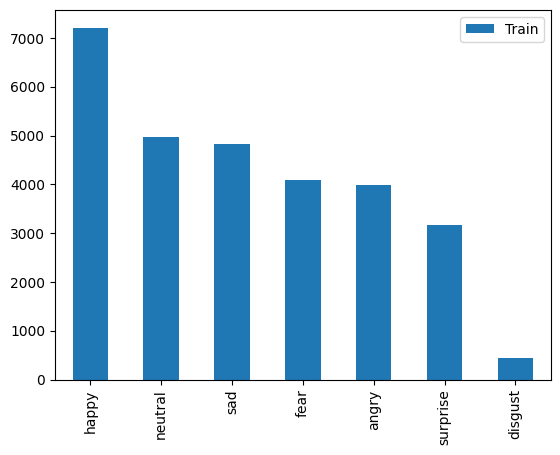

In [ ]:
# Plotting the training counts as a bar chart
Train_Count.plot(kind='bar')

<AxesSubplot:>

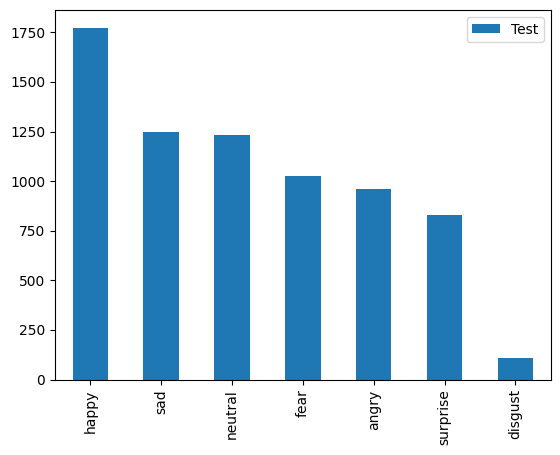

In [ ]:
# Plotting the testing counts as a bar chart
Test_Count.plot(kind='bar')

### Displaying Sample Images from Each Class

The following Python code is used to display a sample image from each class within the training dataset. This is useful for getting a quick visual understanding of what each class represents.

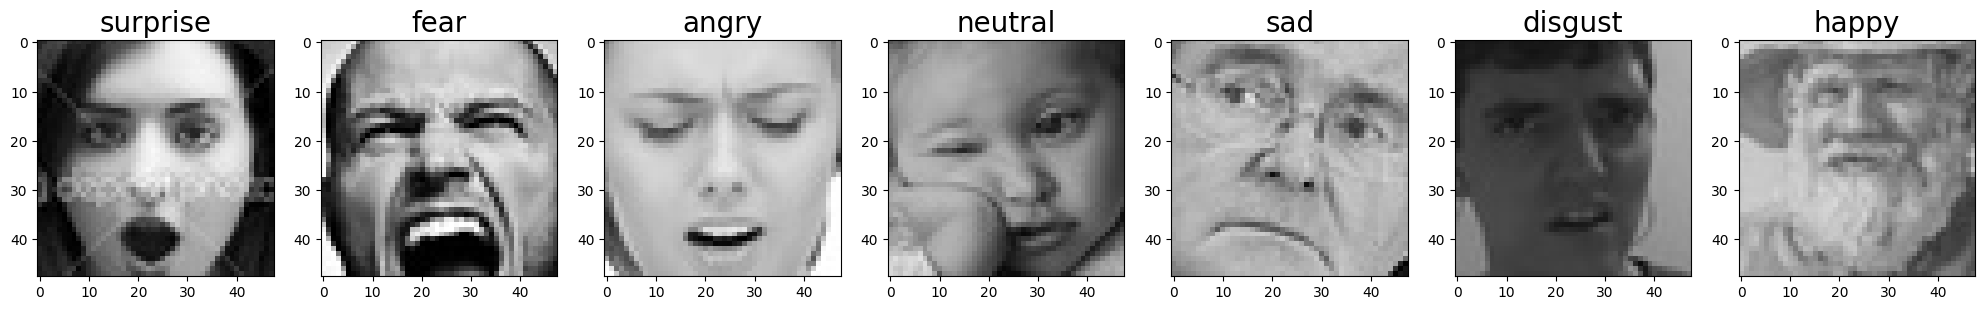

In [ ]:
# Importing required libraries
import os

# Setting the style for matplotlib plots and creating a new figure
plt.style.use('default')
plt.figure(figsize=(25, 8))

# Initializing the image counter and base URL for the training dataset
image_count = 1
BASE_URL = '../input/fer2013/train/'

# Iterating over each directory in the base URL, ignoring hidden directories
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

### Setting Up Image Processing Parameters
The following Python code is used to set up the parameters for image processing. These parameters include the image shape, batch size, and the paths to the training and testing datasets.

In [ ]:
# Setting the image shape to 224x224 pixels
image_shape = 224

# Setting the batch size to 64
batch_size = 64

# Defining the paths to the training and testing datasets
TRAIN_DATA_PATH = '../input/fer2013/train/'
TEST_DATA_PATH = '../input/fer2013/test/'

### Preprocessing and Loading Image Data

The following Python code is used to preprocess and load the image data for both the training and testing datasets. The preprocessing steps include rescaling the images and applying data augmentation techniques to the training data. The data is then loaded using the `flow_from_directory` method, which generates batches of image data from the specified directory.

In [ ]:
# Setting up the image data preprocessor for the training data
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

# Setting up the image data preprocessor for the testing data
test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Loading the training data
train_data = train_preprocessor.flow_from_directory(
    TRAIN_DATA_PATH,
    class_mode="categorical",
    target_size=(image_shape, image_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
)

# Loading the testing data
test_data = test_preprocessor.flow_from_directory(
    TEST_DATA_PATH,
    class_mode="categorical",
    target_size=(image_shape, image_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **MobileNet Model**

### Loading Pretrained MobileNet Model

The following Python code is used to load the pretrained MobileNet model from TensorFlow's `applications` module. The model is loaded without the top (classification) layer and with weights trained on the ImageNet dataset. The input shape is set to match the shape of the images in our dataset.

In [ ]:
# Loading the pretrained MobileNet model without the top layer and with ImageNet weights
mobile_net_model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Displaying the model summary
mobile_net_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

### Freezing Model Layers

The following Python code is used to freeze the layers of the MobileNet model. All layers except the last 20 are frozen, which means that their weights will not be updated during training.

In [ ]:
# Setting the model to be trainable
mobile_net_model.trainable = True

# Freezing all layers except the last 20
for layer in mobile_net_model.layers[:-20]:
    layer.trainable = False

### Creating a Custom Model with MobileNet

The following Python code defines a function to create a custom model that includes the pretrained MobileNet model and additional layers. The additional layers include dropout, batch normalization, flatten, and dense layers.

In [ ]:
# Creating a Sequential model
def create_mobile_net_model():
    model = Sequential([
        mobile_net_model,
        Dropout(0.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

### Setting Up Metrics for Model Evaluation

The following Python code is used to set up the metrics for evaluating the model's performance. These metrics include precision and recall from Keras, and F1 score from scikit-learn.

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

# Setting up Precision metric
model_precision = Precision()

# Setting up Recall metric
model_recall = Recall()

### Compiling and Summarizing the Model

The following Python code is used to create the custom model, display its summary, and compile it with the optimizer, loss function, and metrics.

In [ ]:
# Creating the custom model
custom_model = create_mobile_net_model()

# Displaying the model summary
custom_model.summary()

# Compiling the model with the Adam optimizer, categorical crossentropy loss function, and accuracy, precision, and recall metrics
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', model_precision, model_recall])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 1024)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 1024)        4096      
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3211328   
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

### Setting Up Callbacks and Training Parameters

The following Python code is used to set up callbacks for model training and define the steps per epoch and validation steps. The callbacks include ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau.

In [ ]:
# Setting up the ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint("Model_Checkpoint", monitor="val_accuracy", save_best_only=True)

# Setting up the EarlyStopping callback to stop training when the validation accuracy does not improve
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

# Setting up the ReduceLROnPlateau callback to reduce the learning rate when the validation loss does not improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Combining the callbacks
callbacks_list = [early_stopping, reduce_lr]

# Calculating the steps per epoch and validation steps
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

### Training the Model
The following Python code is used to train the custom model on the training data for a specified number of epochs, with a given batch size, and using the defined callbacks. The model's performance is validated on the testing data.

In [ ]:
# Training the model on the training data
history = custom_model.fit(
    train_data,
    validation_data=test_data,
    epochs=60,
    batch_size=batch_size,
    callbacks=callbacks_list,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/60
448/448 [==============================] - 459s 998ms/step - loss: 1.4520 - accuracy: 0.4818 - precision: 0.6303 - recall: 0.3133 - val_loss: 1.4922 - val_accuracy: 0.4854 - val_precision: 0.6234 - val_recall: 0.3333
Epoch 2/60
448/448 [==============================] - 357s 796ms/step - loss: 1.1611 - accuracy: 0.5714 - precision: 0.7352 - recall: 0.3895 - val_loss: 1.0553 - val_accuracy: 0.6024 - val_precision: 0.7641 - val_recall: 0.4378
Epoch 3/60
448/448 [==============================] - 353s 788ms/step - loss: 1.0937 - accuracy: 0.5996 - precision: 0.7478 - recall: 0.4268 - val_loss: 1.2013 - val_accuracy: 0.5745 - val_precision: 0.6878 - val_recall: 0.4573
Epoch 4/60
448/448 [==============================] - 359s 802ms/step - loss: 1.0412 - accuracy: 0.6197 - precision: 0.7552 - recall: 0.4567 - val_loss: 1.6626 - val_accuracy: 0.4683 - val_precision: 0.5176 - val_recall: 0.4037

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 

# **Evaluating MobileNet**

### Evaluating the Model
The following Python code is used to evaluate the model's performance on the testing data. The loss and accuracy are then printed.

In [ ]:
# Evaluating the model on the testing data
model_score = custom_model.evaluate(test_data)

# Printing the test loss and accuracy
print("Test Loss:     {:.5f}".format(model_score[0]))
print("Test Accuracy: {:.2f}%".format(model_score[1] * 100))

113/113 [==============================] - 18s 155ms/step - loss: 0.9271 - accuracy: 0.6719 - precision: 0.7477 - recall: 0.5880
Test Loss:     0.92709
Test Accuracy: 67.19%


### Plotting Training Metrics

The following Python code defines a function to plot the training and validation loss, accuracy, precision, and recall over the epochs. It then calls this function with the training history.

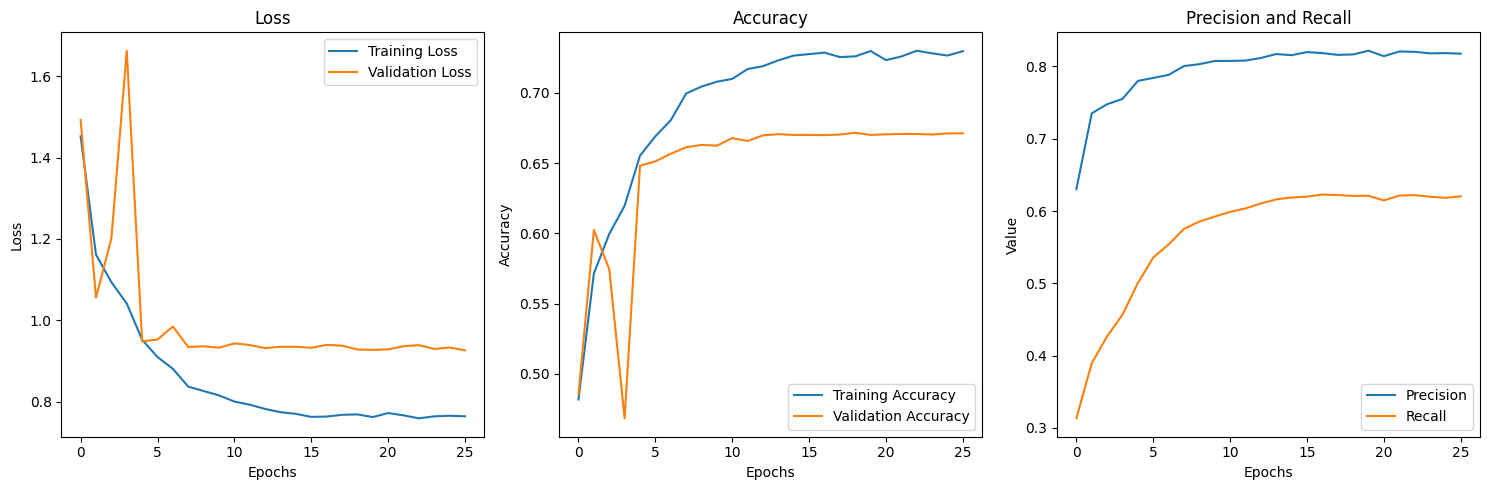

In [ ]:
def plot_metrics(history):
    # List of metrics to plot
    metrics = ['loss', 'accuracy', 'precision', 'recall']

    plt.figure(figsize=(15, 5))

    # Loop over the metrics
    for i, metric in enumerate(metrics):
        # Create a new subplot for each metric
        plt.subplot(1, 4, i+1)

        # Plot the training metric
        plt.plot(history.history[metric], label='Training {}'.format(metric))

        # Plot the validation metric
        plt.plot(history.history['val_{}'.format(metric)], label='Validation {}'.format(metric))

        # Set the title, x-label, y-label, and legend
        plt.title(metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Call the plot_metrics function with the training history
plot_metrics(history)

### Making Predictions with the Model
The following Python code is used to make predictions on the testing data using the trained model. The class with the highest probability is chosen for each prediction.

In [ ]:
# Making predictions on the testing data
predictions = custom_model.predict(test_data)

# Choosing the class with the highest probability for each prediction
predictions = np.argmax(predictions, axis=1)

### Displaying Final Metrics

The following Python code is used to calculate and display the final metrics of the model after training. These metrics include accuracy, precision, recall, validation loss, and F1 score.

In [ ]:
# Extracting the final accuracy, precision, recall, and validation loss from the training history
final_accuracy = history.history['accuracy'][-1]
final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_val_loss = history.history['val_loss'][-1]

# Calculating the final F1 score
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

# Printing the final metrics
print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 72.97%
Final Precision       : 81.77%
Final Recall          : 62.03%
Final Validation Loss : 0.9260
Final F1 Score        : 0.705


### Plotting Confusion Matrix

The following Python code is used to plot a confusion matrix for the model's predictions on the testing data. The confusion matrix is a table that is often used to describe the performance of a classification model.

Text(0.5, 1.0, 'MobileNet Confusion Matrix')

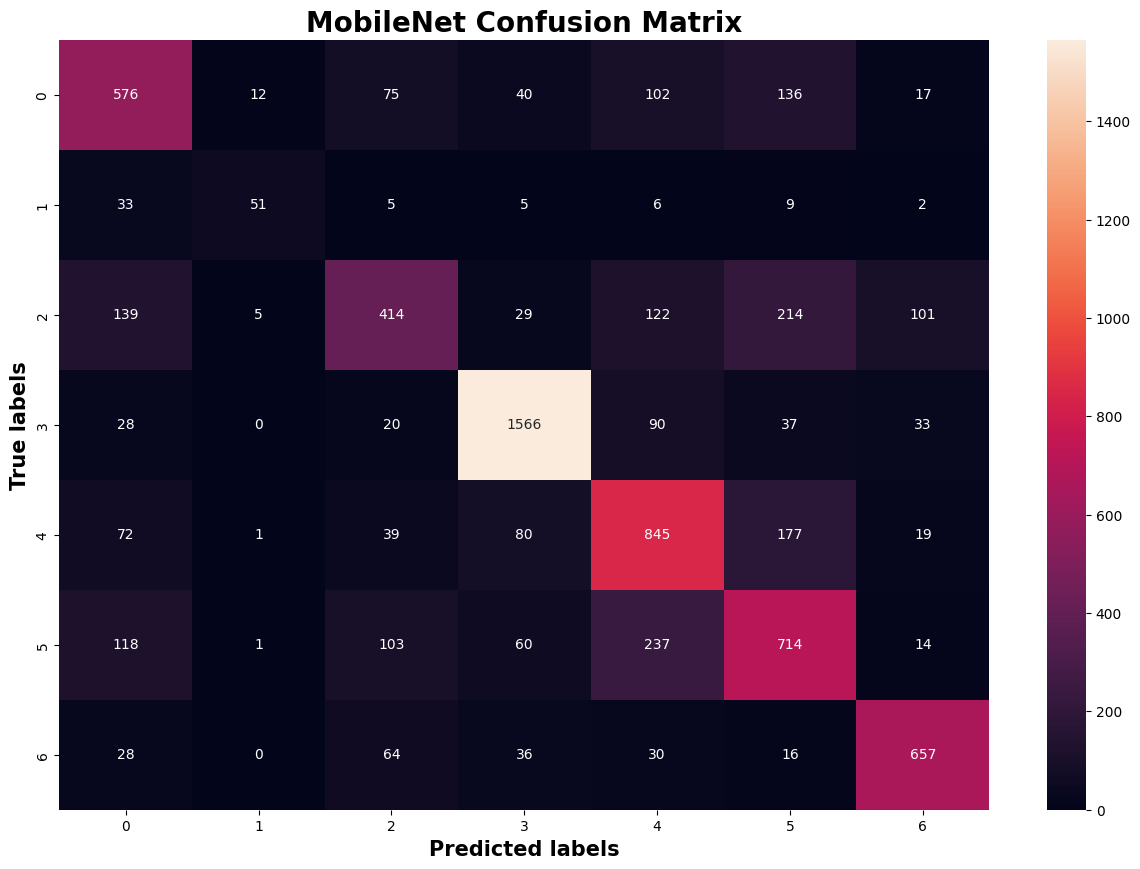

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Creating a confusion matrix from the true labels and the predicted labels
cm = confusion_matrix(test_data.labels, predictions)

# Creating a new figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Creating a heatmap from the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Setting the x-label, y-label, and title
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=20, fontweight='bold')

# Displaying the plot
plt.show()

# **Visualizing Predictions**

### Extracting Class Names

The following Python code is used to extract the class names from the testing data and print them. The class names are capitalized for better readability.

In [ ]:
# Extracting the class indices from the testing data
class_indices = test_data.class_indices

# Capitalizing the class names for better readability
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]

# Printing the class names
print(Emotion_Classes)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


### Preprocessing and Loading Test Data

The following Python code is used to preprocess and load the test data. The images are rescaled, and the data is shuffled to ensure a mix of different classes in each batch.

In [ ]:
# Creating an ImageDataGenerator for test data preprocessing
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

# Loading the test data from a directory
test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


### MobileNet Predictions

The following Python code is used to display random images from the test data along with their true and predicted labels. The title color is green if the prediction is correct and red if it is incorrect.

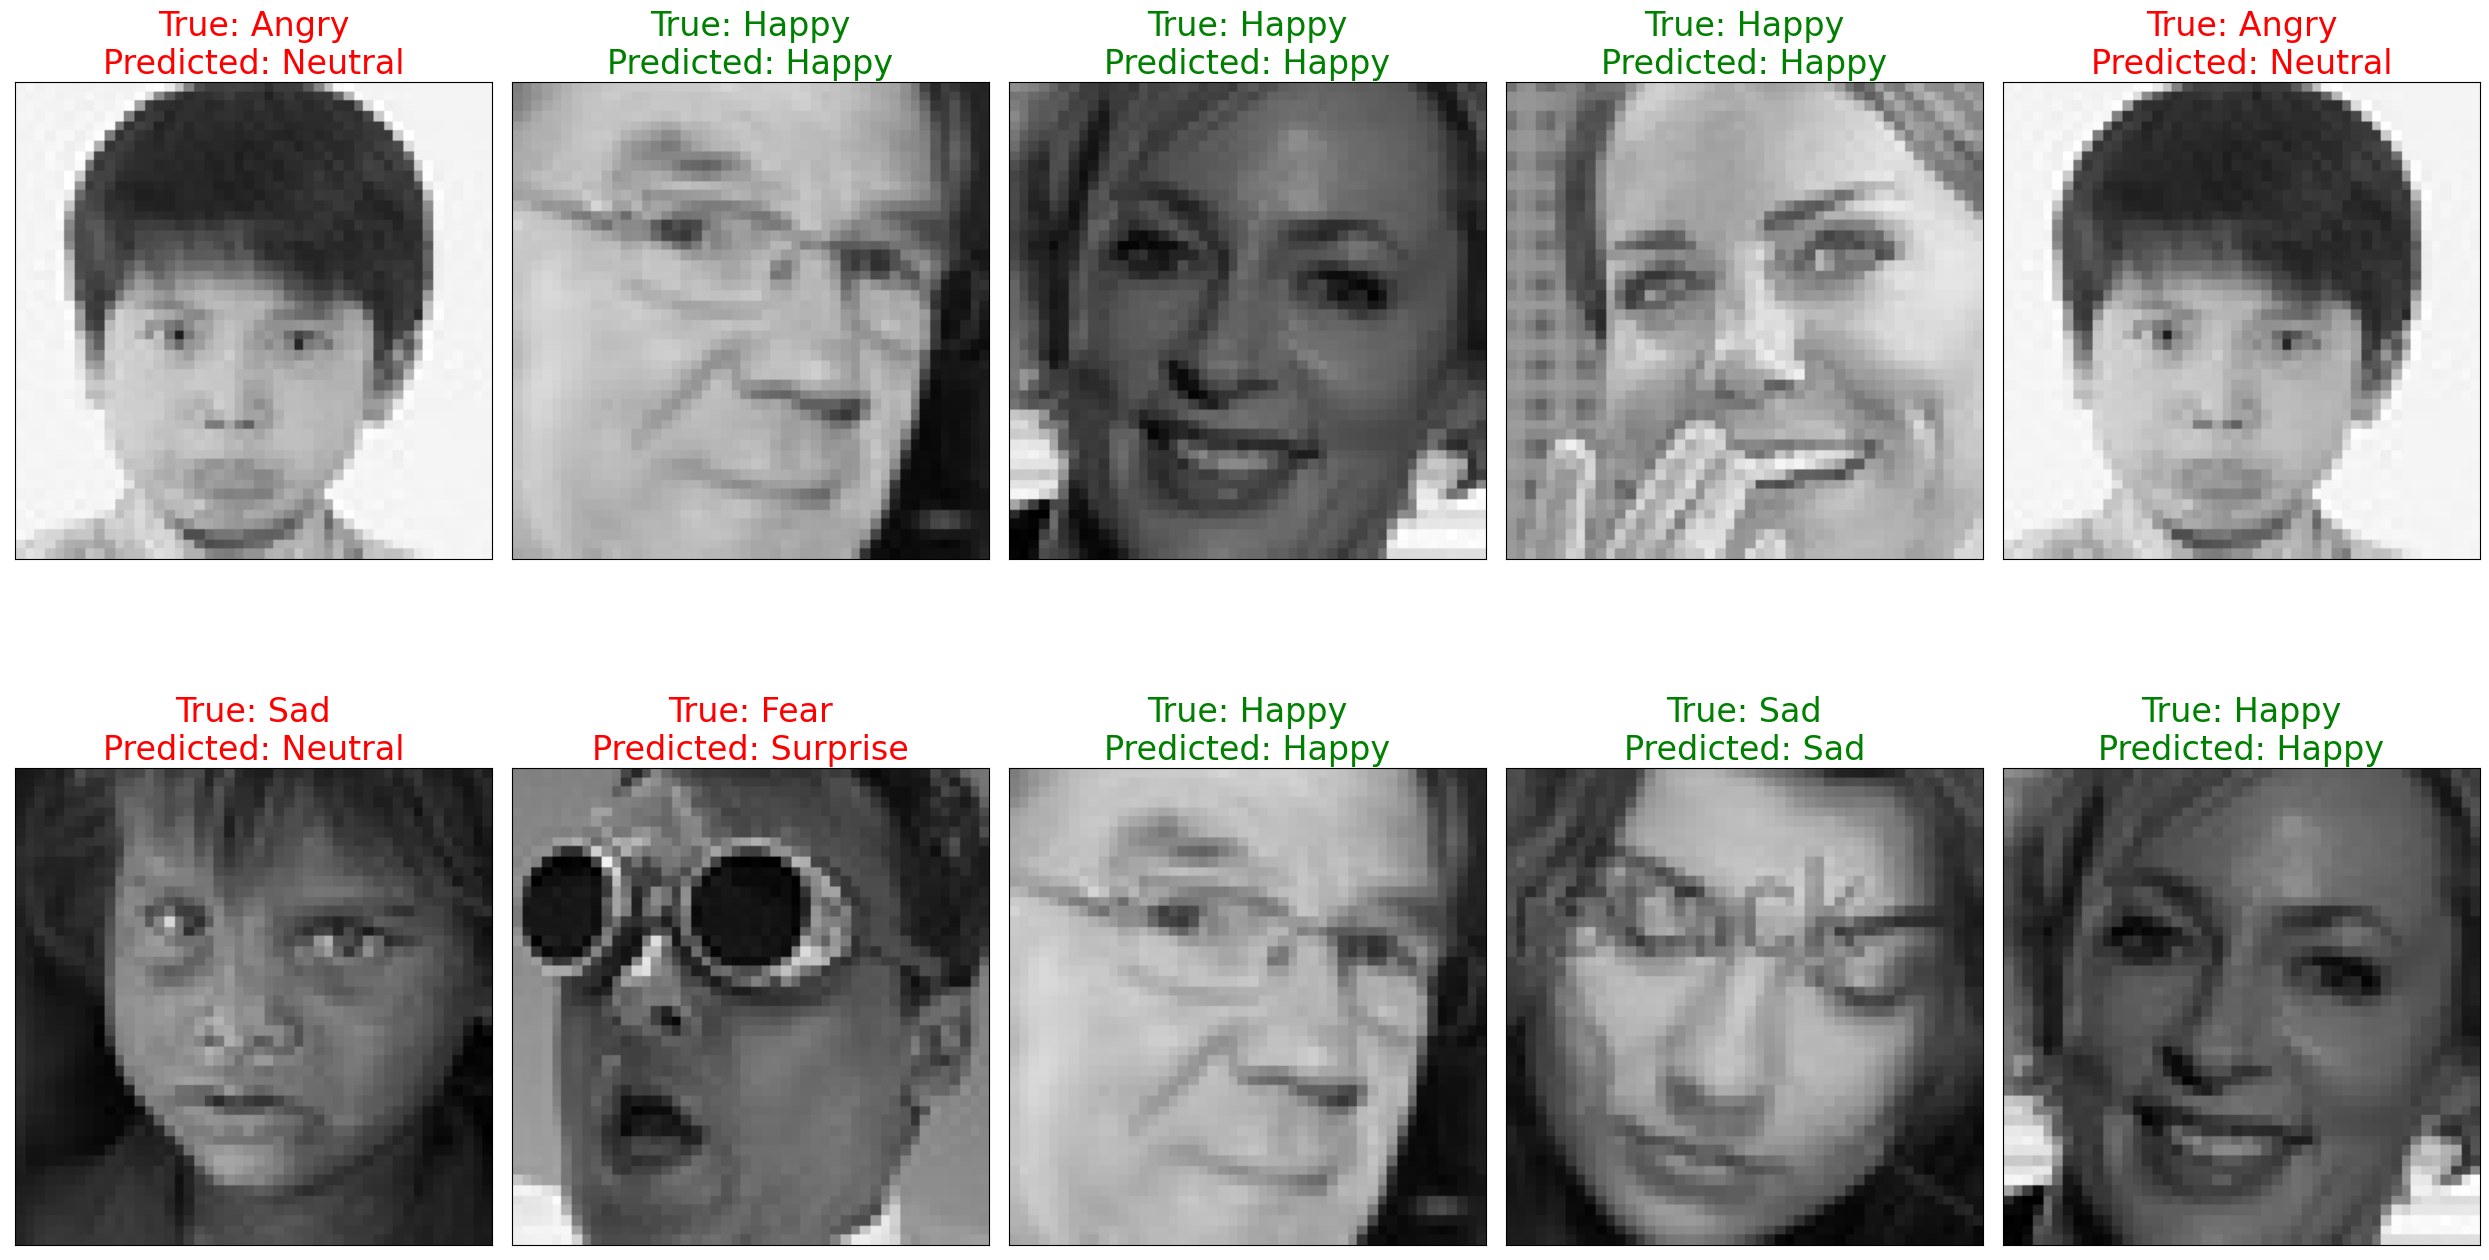

In [ ]:
from skimage.transform import resize

# Selecting a random batch from the test data
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting 10 random images from the batch
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

# Creating a new figure and axes for the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

# Looping over the axes and the random images
for i, ax in enumerate(axes.flat):
    # Selecting a random image and resizing it
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_resized = resize(Random_Img, (224, 224), anti_aliasing=True)

    # Getting the true label and the predicted label for the image
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(MobileNet_Model.predict(Random_Img_resized.reshape(1, 224, 224, 3), verbose=0))

    # Displaying the image
    ax.imshow(Random_Img_resized)

    # Setting the title with the true and predicted labels
    # The title color is green if the prediction is correct and red if it is incorrect
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color, fontsize=24)

# Adjusting the layout and displaying the plot
plt.tight_layout()
plt.show()